In [1]:
import importlib
import os
import random
import time

import import_ipynb
import numpy as np
import pandas as pnd
import requests
import seaborn as sns
from boardgamegeek import BoardGameGeek

from langdetect import detect
from tqdm.notebook import tqdm

import BggDbGetter as BDG
import BggDbScraper as BDS
import BggHelper as BH
import Cicero as Cic
import Glossa as glos

import extra_keras_metrics
import keras.utils
import numpy as np
import tensorflow as tf
from keras import backend as B
from keras.layers import BatchNormalization, Dense
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from matplotlib import pyplot as plt
from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from tqdm import tqdm_notebook as tqdm

importing Jupyter notebook from BggDbGetter.ipynb
importing Jupyter notebook from BggDbScraper.ipynb
importing Jupyter notebook from BggHelper.ipynb
importing Jupyter notebook from Cicero.ipynb
importing Jupyter notebook from Glossa.ipynb


Using TensorFlow backend.


# Step 1

Access BBG API's to download game and user preferences data.
Define criterion used for setting the parameters that drive the download in termis of the variables defining the dataset, such collecting games only for a specified period or a specified set of categories. The wider the game collection, the better.

In [2]:
helper = BH.BggHelper()
new_df = helper.bgg_start(get=False, scrape=False)

#### Dataframe reading

In [3]:
df = pnd.read_csv("BGG_sampled.csv")
dfh = df[df["mechanics"] != "[]"]
dfh = dfh[dfh["description"] != "[]"]
dfh = dfh[dfh["families"] != "[]"]
dfh = dfh[dfh["categories"] != "[]"]
#dfh = df
#dfh["families"][0], dfh["categories"][0], dfh["mechanics"][0]

In [4]:
gls = glos.Glossa(dfh, "en")
cicero = Cic.Cicero(gls)

In [ ]:
cicero = cicero.clean_lemming("description")

In [ ]:
cicero = cicero.clean_lemming("categories")

In [7]:
#cicero = cicero.eng_lemming("name")
cicero = cicero.eng_lemming("publishers")

In [8]:
cicero = cicero.eng_lemming("families")

In [9]:
cicero = cicero.eng_lemming("mechanics")

In [10]:
cicero.get_df()["publishers"][0]

'cephalofair game albi asmodee feuerland spiele galápagos jogos game warehouse gém klub kft. hobby world korea boardgames co. ltd. mybg co. ltd'

In [11]:
cicero.get_df()["categories"][0]

'adventure exploration fantasy fighting miniature'

In [12]:
year_tag_analysis = dfh[["name", "mechanics", "families", "categories", "yearpublished"]]

# Step 2

Pre-process game text (title and description) in order to define the terms to include in the variables to be observed, eventually using a word embedding model to normalize and/or expand the terminology extracted from the game description.

## Followed  this url:
### https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92


#### Need to create a column in the dataframe containing all the important words in the row. <br> This takes into account Name, description, mechanics, families and publishers

In [13]:
df.columns

Index(['Unnamed: 0', 'boardgame_rank', 'id', 'families', 'categories',
       'mechanics', 'designers', 'artists', 'publishers', 'description',
       'yearpublished', 'minplayers', 'maxplayers', 'playingtime', 'minage',
       'name', 'usersrated', 'average', 'bayesaverage', 'stddev', 'owned',
       'numweights', 'averageweight', 'ranks'],
      dtype='object')

In [14]:
dimensions = 150
model, corpus = cicero.word2vec_train(["description", "mechanics", "categories", "families", "publishers"], dimensions=dimensions, sg=1)

In [15]:
## Pass to Pitagora class text corpus and model
## Pitagora will return a vector of dimension D'

import Pitagora as ptg
import importlib
importlib.reload(ptg)

quantity = 20
pitagora = ptg.Pitagora(corpus, model)

importing Jupyter notebook from Pitagora.ipynb
importing Jupyter notebook from Pitagora.ipynb


In [16]:
cps = pitagora.topwords_extraction(quantity=quantity)

In [17]:
j = 0
variables = cicero.get_df()
trainset = []
for element in tqdm(cps):
    trainset.append((element, variables.loc[j, [
        "name", "boardgame_rank", "averageweight", "average", "yearpublished",
        "playingtime", "minplayers", "maxplayers", "minage"
    ]]))
    j += 1
#variables.loc[j, ["name", "id"]][1]#[["name", "id"]]

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [18]:
embeddings = []
i = 0

In [19]:
for element in tqdm(trainset):
    foster_element = []
    try:
        for word in element[0]:
            foster_element.append(model[word].tolist())
        if len(foster_element) < quantity:
            foster_element = []
        else:
            embeddings.append((foster_element, element[1]))
    except:
        print("Absent word: ", word, " - From game: ", element[1])
        i += 1
        pass

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


### Once "embeddings" has been obtained, it must be compressed via a transformer
##### Each list contains 10 words, post embedding each word becomes a list of 100 values. 
100 values * 10 words = 1000 values <br>

Two possible paths: <br>
1] Neural network with 1000 neurons as input layers [OUT OF QUESTION]<br>
2] Compression of each 10 terms of 100 values each into one single vector of length D', in order to make an input layer of D' neurons [FEASIBLE WITH SKLEARN.DECOMPOSITION'S PCA IMPLEMENTATION]-> No! Use Autoencoder with NN! <br>



In [20]:
j = 0
x, x_elem = [], []#np.array([]), []
#y = np.array([])
y_rank, y_weight, y_vote = [], [], []
for i in tqdm(embeddings):
    #y = np.concatenate(y, np.array([i[1]]))
    #y.append(i[1][1:])
    y_rank.append(i[1][1])
    y_weight.append(i[1][2])
    y_vote.append(i[1][3])
    #change here from 20 to 10
    while j < quantity:
        x_elem += i[0][j]
        j += 1
    #x = np.concatenate(x, np.array(x_elem))
    x_elem.append(i[1][4])
    x_elem.append(i[1][5])
    x_elem.append(i[1][6])
    x_elem.append(i[1][7])
    x_elem.append(i[1][8])
    x.append(np.array(x_elem))
    x_elem = []
    j = 0
#i = embeddings[0][0]
#i

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [21]:
rankmax = max(y_rank)
y_rank = list(map(lambda y: y/rankmax, y_rank))
y_weight = list(map(lambda y: y*(1/5), y_weight))
y_vote = list(map(lambda y: y/10, y_vote))

In [22]:
import Hephaestus

importing Jupyter notebook from Hephaestus.ipynb
importing Jupyter notebook from Athena.ipynb


In [23]:
importlib.reload(Hephaestus)

importing Jupyter notebook from Hephaestus.ipynb


<module 'Hephaestus' from 'Hephaestus.ipynb'>

In [24]:
def plot_graphs(history, name, interpolate=False):
    print(name)
    i = 0
    for fold in history:
        #path_name = "Graphs/" + "Quantity" + str(quantity) + "/4Layers64NeuSec/" + name + "/" + str(i)
        path_name = "Graphs/Dim" + str(dimensions) + "/Quantity" + str(quantity) + "/4Layers64NeuSec/" + name + "/" + str(i)
        plot_history(fold.history, path=path_name, interpolate=interpolate)
        i += 1

#### Shuffling phase

In [25]:
z = list(zip(x, y_rank))
random.shuffle(z)
x, y_rank = zip(*z)

In [ ]:
#hephaestus_rank = Hephaestus.Hephaestus(model_rank, x, y_rank)
hephaestus_rank = Hephaestus.Hephaestus(embeddings, x, y_rank)

In [ ]:
histories_rank = hephaestus_rank.kfold_x_validation(batch=1028, folds=5)

In [ ]:
plot_graphs(histories_rank, "Rank")

In [ ]:
a, b = 0, 0
for h in histories_rank:
    a += h.history["val_loss"][-1]
    b += h.history["val_mae"][-1]
a, b = a / 5, b / 5

In [ ]:
path_name = "Graphs/Dim" + str(dimensions) + "/Quantity" + str(quantity) + "/4Layers64NeuSec/" + "Rank" + "/"
f = open(path_name+"metrics.txt", "w+")
f.write("MSE: {0}\nMAE: {1}".format(a, b))
f.close()
#path_name

In [ ]:
hephaestus_weight = Hephaestus.Hephaestus(embeddings, x, y_weight)
#(model_classic_weight, x, y_weight)

In [ ]:
histories_weight = hephaestus_weight.kfold_x_validation(batch=1028, folds=5)

In [ ]:
plot_graphs(histories_weight, "Weight")

In [ ]:
val_loss, val_mae = 0, 0
for h in histories_weight:
    val_loss += h.history["val_loss"][-1]
    val_mae += h.history["val_mae"][-1]
val_loss, val_mae = val_loss / 5, val_mae / 5

In [ ]:
path_name = "Graphs/Dim" + str(dimensions) + "/Quantity" + str(quantity) + "/4Layers64NeuSec/" + "Weight" + "/"
f = open(path_name+"metrics.txt", "w+")
f.write("MSE: {0}\nMAE: {1}".format(val_loss, val_mae))
f.close()
#path_name

In [26]:
hephaestus_vote = Hephaestus.Hephaestus(embeddings, x, y_vote)
#(model_classic_vote, x, y_vote)

In [27]:
histories_vote = hephaestus_vote.kfold_x_validation(batch=1028, folds=5)

Vote


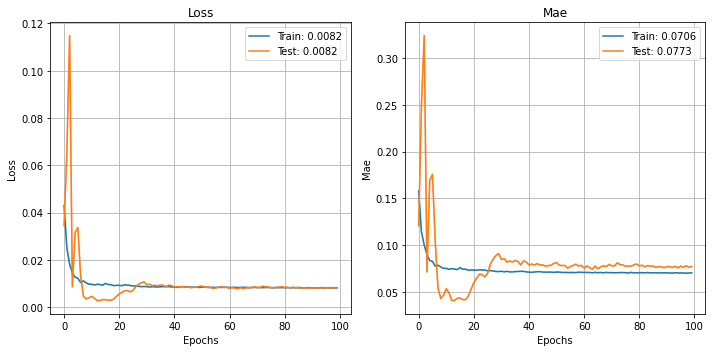

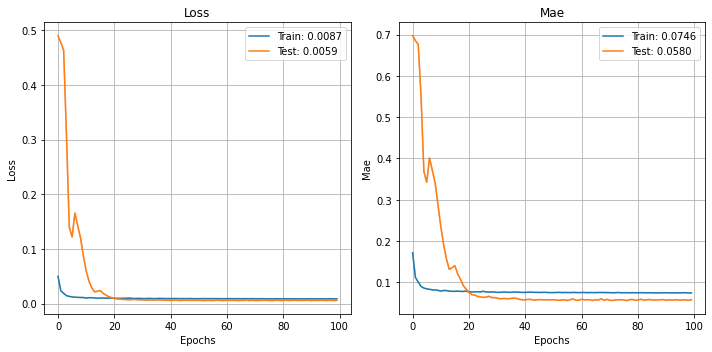

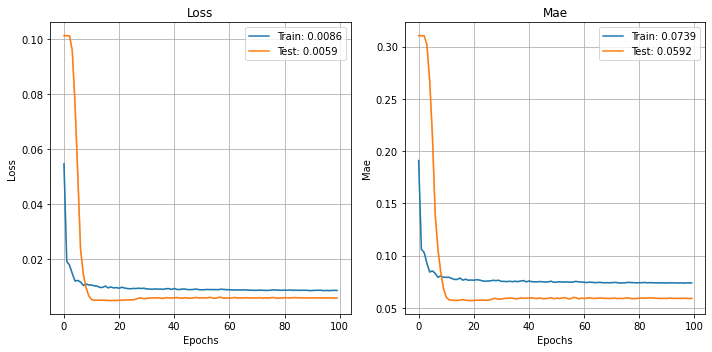

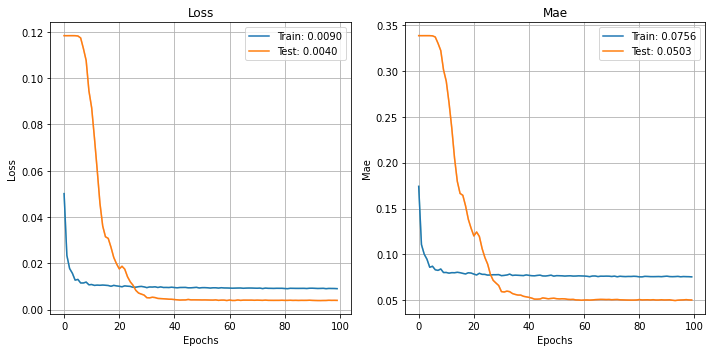

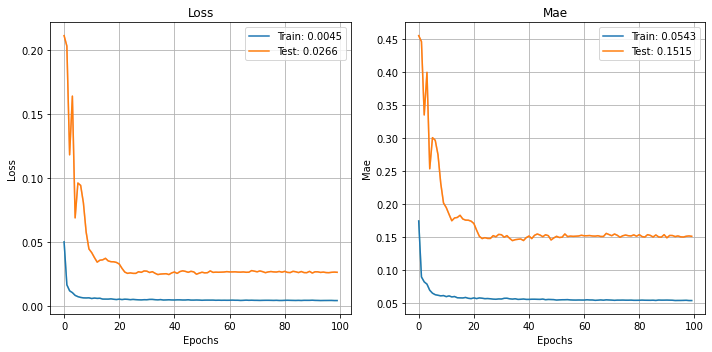

In [28]:
plot_graphs(histories_vote, "Vote")

In [29]:
val_loss, val_mae = 0, 0
for h in histories_vote:
    val_loss += h.history["val_loss"][-1]
    val_mae += h.history["val_mae"][-1]
val_loss, val_mae = val_loss / 5, val_mae / 5

In [30]:
path_name = "Graphs/Dim" + str(dimensions) + "/Quantity" + str(quantity) + "/4Layers64NeuSec/" + "Vote" + "/"
f = open(path_name+"metrics.txt", "w+")
f.write("MSE: {0}\nMAE: {1}".format(val_loss, val_mae))
f.close()
#path_name

# Step 3

## Variables to be observed:

<table style="width:100%">
  <tr>
    <th>Objective</th>
    <th>Subjective</th>
  </tr>
  <tr>
    <td>Name</td>
    <td>User rating</td>
  </tr>
  <tr>
    <td>Description</td>
    <td>Average</td>
  </tr>
  <tr>
    <td>Categories</td>
    <td>Average Weight</td>
  </tr>
  <tr>
    <td>Families</td>
    <td>Owned</td>
  </tr>
  <tr>
    <td>Publishers</td>
    <td>Rank</td>
  </tr>
  <tr>
    <td>Mechanics</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
  </tr>
</table>

 ##### Embeddings is shaped as a list of lists, each containing both the overall embeddings and the corresponding subjective informations about the game.
Each list contains a 100-dimensional list 

In [ ]:
#a = (cicero.get_df()["mechanics"][0]).strip("[").strip("]").split(",")
#.replace("'", "")
#[x.replace("'", "").strip() for x in a]

In [5]:
year_tag_analysis = dfh[["name", "mechanics", "families", "categories", "yearpublished"]]
year_tag_analysis = year_tag_analysis[year_tag_analysis["mechanics"] != "[]"]
year_tag_analysis = year_tag_analysis[year_tag_analysis["families"] != "[]"]
year_tag_analysis = year_tag_analysis[year_tag_analysis["categories"] != "[]"]

In [6]:
mechanics_year_list = []
families_year_list = []
cats_year_list = []
for index, row in tqdm(year_tag_analysis.iterrows()):
    mechanics_year_list += [(x.replace("'", "").replace("\"", "").strip().lower(), row["yearpublished"]) for x in ((row["mechanics"].strip("[").strip("]")).split(","))]
    families_year_list += [(x.replace("'", "").replace("\"", "").strip().lower(), row["yearpublished"]) for x in ((row["families"].strip("[").strip("]")).split(",")) if x.replace("'", "").replace("\"", "").strip().lower() != "admin: better description needed!"]
    cats_year_list += [(x.replace("'", "").replace("\"", "").strip().lower(), row["yearpublished"]) for x in ((row["categories"].strip("[").strip("]")).split(","))]

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [7]:
cats_year_list

[('adventure', 2017),
 ('exploration', 2017),
 ('fantasy', 2017),
 ('fighting', 2017),
 ('miniatures', 2017),
 ('environmental', 2015),
 ('medical', 2015),
 ('economic', 2016),
 ('environmental', 2016),
 ('industry / manufacturing', 2016),
 ('science fiction', 2016),
 ('space exploration', 2016),
 ('territory building', 2016),
 ('economic', 2018),
 ('industry / manufacturing', 2018),
 ('transportation', 2018),
 ('card game', 2015),
 ('civilization', 2015),
 ('economic', 2015),
 ('civilization', 2017),
 ('economic', 2017),
 ('negotiation', 2017),
 ('political', 2017),
 ('science fiction', 2017),
 ('space exploration', 2017),
 ('wargame', 2017),
 ('civil war', 2016),
 ('fighting', 2016),
 ('miniatures', 2016),
 ('movies / tv / radio theme', 2016),
 ('science fiction', 2016),
 ('wargame', 2016),
 ('modern warfare', 2005),
 ('political', 2005),
 ('wargame', 2005),
 ('civilization', 2017),
 ('economic', 2017),
 ('science fiction', 2017),
 ('space exploration', 2017),
 ('territory building',

In [8]:
set_mechs, set_fams, set_cats = set(mechanics_year_list), set(families_year_list), set(cats_year_list)
sorted_mechs, sorted_fams, sorted_cats = sorted(mechanics_year_list), sorted(families_year_list), sorted(cats_year_list)

In [9]:
years_mechs, years_fams, years_cats = [], [], []
for i in range(2000, 2021):
    years_mechs.append(sorted([x for x in sorted_mechs if x[1] == i], key=lambda x: x[0], reverse=True))
    years_fams.append(sorted([x for x in sorted_fams if x[1] == i], key=lambda x: x[0], reverse=True))
    years_cats.append(sorted([x for x in sorted_cats if x[1] == i], key=lambda x: x[0], reverse=True))

In [10]:
freq_mechs_years, freq_fams_years, freq_cats_years = [], [], []
for year in years_mechs:
    set_year = set(year)
    freq_year = []
    for tag in set_year:
        #"{:.5%}".format
        freq_year += [(year.count(tag)/len(year), tag[0], tag[1])]
    freq_mechs_years.append(sorted(freq_year, key=lambda x: x[0], reverse=True))

In [11]:
for year in years_fams:
    set_year = set(year)
    freq_year = []
    for tag in set_year:
        #"{:.5%}".format
        freq_year += [(year.count(tag)/len(year), tag[0], tag[1])]
    freq_fams_years.append(sorted(freq_year, key=lambda x: x[0], reverse=True))

In [12]:
for year in years_cats:
    set_year = set(year)
    freq_year = []
    for tag in set_year:
        #"{:.5%}".format
        freq_year += [(year.count(tag)/len(year), tag[0], tag[1])]
    freq_cats_years.append(sorted(freq_year, key=lambda x: x[0], reverse=True))

freq_fams_years[0][0][0]
sm = 0
for year in freq_fams_years[0]:
    sm += year[0]
print(sm)

In [13]:
topmost_by_year_mechs, topmost_by_year_fams, topmost_by_year_cats = [], [], []
for year in freq_mechs_years:
    topmost_by_year_mechs.append(year[:10])
for year in freq_fams_years:
    topmost_by_year_fams.append(year[:10])
for year in freq_cats_years:
    topmost_by_year_cats.append(year[:10])

In [14]:
topmost_by_year_cats

[[(0.09683426443202979, 'card game', 2000),
  (0.07262569832402235, 'wargame', 2000),
  (0.054003724394785846, 'movies / tv / radio theme', 2000),
  (0.048417132216014895, 'childrens game', 2000),
  (0.040968342644320296, 'fantasy', 2000),
  (0.035381750465549346, 'fighting', 2000),
  (0.0297951582867784, 'economic', 2000),
  (0.0297951582867784, 'negotiation', 2000),
  (0.0260707635009311, 'science fiction', 2000),
  (0.0260707635009311, 'party game', 2000)],
 [(0.09851301115241635, 'card game', 2001),
  (0.08364312267657993, 'wargame', 2001),
  (0.04460966542750929, 'childrens game', 2001),
  (0.04460966542750929, 'fantasy', 2001),
  (0.03717472118959108, 'world war ii', 2001),
  (0.03531598513011153, 'economic', 2001),
  (0.03531598513011153, 'fighting', 2001),
  (0.03531598513011153, 'movies / tv / radio theme', 2001),
  (0.031598513011152414, 'science fiction', 2001),
  (0.031598513011152414, 'abstract strategy', 2001)],
 [(0.08520900321543408, 'wargame', 2002),
  (0.0803858520900

In [15]:
#topmost_by_year_fams

In [16]:
mechs_whole, fams_whole, cats_whole = [], [], []
for year in freq_mechs_years:
    mechs_whole += year
for year in freq_fams_years:
    fams_whole += year
for year in freq_cats_years:
    cats_whole += year

In [17]:
all_mechs_names, all_fams_names, all_cats_names = [], [], []
for year in topmost_by_year_mechs:
    for tag in year:
        all_mechs_names += [tag[1]]
for year in topmost_by_year_fams:
    for tag in year:
        all_fams_names += [tag[1]]
for year in topmost_by_year_cats:
    for tag in year:
        all_cats_names += [tag[1]]
#set(all_mechs_names), set(all_fams_names)

In [18]:
## Every tuple <percentage, game name, year> in topmost_by_year_mechs / fams
## gets searched in the overall frequencies of all mechs  and / or fams in order
## to plot an overall trending graph for each one of them
growth_mechs = []
scanned = []
for year in tqdm(topmost_by_year_mechs):
    for tag in year:
        stub = [x for x in mechs_whole if x not in scanned and x[1] == tag[1]]
        if stub not in scanned:
            growth_mechs.append(stub)
        scanned.append(stub)

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [19]:
growth_fams = []
scanned = []
for year in tqdm(topmost_by_year_fams):
    for tag in year:
        stub = [x for x in fams_whole if x not in scanned and x[1] == tag[1]]
        if stub not in scanned:
            growth_fams.append(stub)
        scanned.append(stub)

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
growth_cats = []
scanned = []
for year in tqdm(topmost_by_year_cats):
    for tag in year:
        stub = [x for x in cats_whole if x not in scanned and x[1] == tag[1]]
        if stub not in scanned:
            growth_cats.append(stub)
        scanned.append(stub)

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [103]:
cats_ranks, cats_rates = [], []
for element in growth_cats:
    support = []
    #print("Growth of {0}: ".format(element[0][1]))
    for pop in range(1, len(element)):
        support += [(element[pop][0] - element[pop-1][0])*100/element[pop-1][0]]
        #print(support)
    cats_ranks.append((support, element[0][1]))

for element in cats_ranks:
    el = element[0]
    support = []
    for pop in range(1, len(el)):
        support += [(((el[pop] / el[pop-1])**(1/len(el)))-1)*100]
    cats_rates.append((sum(support).real/len(support), element[1]))
#sorted(cats_rates, key=lambda x: x[0], reverse=True)[:5]
path_name = "Graphs/Tendencies/Categories/"
f = open(path_name+"Average_Growth_Rates_per_Category.txt", "w+")
for x in sorted(cats_rates, key=lambda x: x[0], reverse=True):
    f.write("{0}:\t\t{1}\n".format(x[0], x[1]))
f.close()

In [105]:
mechs_ranks, mechs_rates = [], []
for element in growth_mechs:
    support = []
    #print("Growth of {0}: ".format(element[0][1]))
    for pop in range(1, len(element)):
        support += [(element[pop][0] - element[pop-1][0])*100/element[pop-1][0]]
        #print(support)
    mechs_ranks.append((support, element[0][1]))

for element in mechs_ranks:
    el = element[0]
    support = []
    for pop in range(1, len(el)):
        support += [(((el[pop] / el[pop-1])**(1/len(el)))-1)*100]
    mechs_rates.append((sum(support).real/len(support), element[1]))
#sorted(mechs_rates, key=lambda x: x[0], reverse=True)[:5]
path_name = "Graphs/Tendencies/Mechanics/"
f = open(path_name+"Average_Growth_Rates_per_Mechanic.txt", "w+")
for x in sorted(mechs_rates, key=lambda x: x[0], reverse=True):
    f.write("{0}:\t\t{1}\n".format(x[0], x[1]))
f.close()

In [107]:
fams_ranks, fams_rates = [], []
for element in growth_fams:
    support = []
    #print("Growth of {0}: ".format(element[0][1]))
    for pop in range(1, len(element)):
        support += [(element[pop][0] - element[pop-1][0])*100/element[pop-1][0]]
        #print(support)
    fams_ranks.append((support, element[0][1]))

for element in fams_ranks:
    el = element[0]
    support = []
    for pop in range(1, len(el)):
        support += [(((el[pop] / el[pop-1])**(1/len(el)))-1)*100]
    try:
        fams_rates.append((sum(support).real/len(support), element[1]))
    except:
        pass
#for x in (sorted(fams_rates, key=lambda x: x[0], reverse=True)):
path_name = "Graphs/Tendencies/Families/"
f = open(path_name+"Average_Growth_Rates_per_Family.txt", "w+")
for x in sorted(fams_rates, key=lambda x: x[0], reverse=True):
    f.write("{0}:\t\t{1}\n".format(x[0], x[1]))
f.close()
    

In [22]:
bag_and_pool_building = []
for el in growth_mechs: 
    bag_and_pool_building += [(x[0], "bag and pool building", x[2]) for x in el if x[1] == "bag"]


In [23]:
#import matplotlib as plt
bag_and_pool_building

[(0.0020964360587002098, 'bag and pool building', 2000),
 (0.001876172607879925, 'bag and pool building', 2002),
 (0.0012642225031605564, 'bag and pool building', 2004),
 (0.001059322033898305, 'bag and pool building', 2005),
 (0.0010799136069114472, 'bag and pool building', 2007),
 (0.001936108422071636, 'bag and pool building', 2008),
 (0.004796163069544364, 'bag and pool building', 2009),
 (0.0077738515901060075, 'bag and pool building', 2010),
 (0.017082785808147174, 'bag and pool building', 2011),
 (0.01668520578420467, 'bag and pool building', 2012),
 (0.02288911495422177, 'bag and pool building', 2013),
 (0.02556818181818182, 'bag and pool building', 2014),
 (0.023131672597864767, 'bag and pool building', 2015),
 (0.027979274611398965, 'bag and pool building', 2016),
 (0.023887434554973823, 'bag and pool building', 2017),
 (0.02574441687344913, 'bag and pool building', 2018),
 (0.021449704142011833, 'bag and pool building', 2019)]

In [ ]:
for graph in growth_mechs:
    label_years = [x[2] - 2000 for x in graph]
    plt.xticks(range(0, 21), label_years)
    title = graph[0][1]
    path = "Graphs/Tendencies/Mechanics/" + title.replace("/", " ") + ".png"
    print(path)
    plt.suptitle(title)
    #plt.title("Delta: " + str(round(graph[-1][0] - graph[0][0], 4)))
    plt.plot([x[0] for x in graph])
    plt.savefig(fname=path)
    plt.show()
    #

In [ ]:
a, b = [], []
for x in growth_mechs:
    a += [x[-1]]
    b += [x[0]]
deltas = []
for i in range(len(a)):
    deltas += [((a[i][0] - b[i][0]), a[i][1], a[i][2])]
sorted(deltas)

In [ ]:
for graph in growth_fams:
    #label_years = [x[2] - 2000 for x in graph]
    plt.xticks(range(0, 21), [x for x in range(0, 21)])
    title = graph[0][1]
    path = "Graphs/Tendencies/Families/" + title.replace("/", " ") + ".png"
    plt.suptitle(title)
    #plt.title("Delta: {0}".format(round((graph[-1][0] - graph[0][0])*100/len(graph), 4)))
    plt.plot([x[0] for x in graph])
    plt.savefig(fname=path)
    plt.show()

In [ ]:
for graph in growth_cats:
    #label_years = [x[2] - 2000 for x in graph]
    plt.xticks(range(0, 21), [x for x in range(0, 21)])
    title = graph[0][1]
    path = "Graphs/Tendencies/Categories/" + title.replace("/", " ") + ".png"
    plt.suptitle(title)
    #plt.title("Delta: " + str(round(graph[-1][0] - graph[0][0], 4)))
    plt.plot([x[0] for x in graph])
    plt.savefig(fname=path)
    plt.show()

## Step 4
Include in the paper a report describing the output of Step 3